# **Germany data**

Running this notebook does not require a GPU. You can use a frontal node. However, certain parts such as detecting bounding boxes or removing the background from images require GPUs which are launched in external jobs.

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [4]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import check_filepath, flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

In [5]:
# GPU parameters for jobs to be launched (MegaDetector + SAM)
MODULE = 'pytorch-gpu/py3/2.2.0'
account = 'ads@v100'

In [6]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")
COUNTRY = "germany"
GERMANY_DATASET_PATH = DATASET / "germany/BFNP_Heurich"
NO_BACKGROUND = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new")

---

## **Get images (filepath + lynx_id)**

In [14]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
}

In [15]:
def parse_filename(filename):
    parts = filename.split("BFNP_Heurich/")[1:][0].split("/")[1:]
    
    lynx_id = parts[0]
    
    return {"lynx_id": lynx_id}

In [16]:
img_nok = 0

for current_directory, _, files in os.walk(GERMANY_DATASET_PATH):
    for file in files:
        absolute_path = os.path.abspath(os.path.join(current_directory, file))
        if re.compile(r'\.(jpg|jpeg|png)$', re.IGNORECASE).search(absolute_path) and 'B0' not in absolute_path:
            
            try:
                parsed = parse_filename(absolute_path)

                dataset_dict['filepath'].append(absolute_path)
                dataset_dict['lynx_id'].append(parsed['lynx_id'])
            except:
                img_nok += 1

print(f"{img_nok=}")

img_nok=0


In [17]:
df_country = pd.DataFrame(dataset_dict)
df_country

,filepath,lynx_id
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope
...,...,...
5958,/gpfsscratch/rech/ads/commun/datasets/extracte...,Luha
5959,/gpfsscratch/rech/ads/commun/datasets/extracte...,B31_Geli_Luna_Juv.13_1
5960,/gpfsscratch/rech/ads/commun/datasets/extracte...,B31_Geli_Luna_Juv.13_1
5961,/gpfsscratch/rech/ads/commun/datasets/extracte...,B266_Juvenil Neu_2013


In [18]:
df_country.nunique()

filepath    5963
lynx_id      245
dtype: int64

In [21]:
df_country['lynx_id'].value_counts()

lynx_id
B38_Stefan                   494
B238_Rico                    481
B500_Patrik                  460
B224_Nora                    347
B23_Hakerl                   274
                            ... 
Geli_Juv.15-2                  1
B48                            1
B45_Gregor_Luna_Juv.15-1       1
R216                           1
L201_Neu_2_ev.Nora_Juv.09      1
Name: count, Length: 245, dtype: int64

### **Deleting broken images**

In [19]:
all_files_exist = all(df_country['filepath'].apply(os.path.exists))
all_files_exist

True

## **Bounding box detection**

In [22]:
country_output_megadetector = DATASET / COUNTRY / f"bbox_{COUNTRY}.json"  # WARNING: change filename if needed
country_output_megadetector

PosixPath('/gpfsscratch/rech/ads/commun/datasets/extracted/germany/bbox_germany.json')

In [23]:
image_filenames = df_country['filepath'].tolist()
len(image_filenames)

5963

In [24]:
# Bounding box calculation is externalised to another job
image_filenames_path = f"image_filenames_{COUNTRY}.txt"
with open(image_filenames_path, 'w') as f:
    json.dump(image_filenames, f)

n_gpu = 1
command = f'run_megadetector.py --image_filenames_path {image_filenames_path} --output_megadetector {country_output_megadetector}'

jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=f"megadetector_{COUNTRY}",
                   account=account, time_max='04:00:00', constraint='v100-32g', qos='qos_gpu-t3')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 10 cpus per task
Submitted batch job 326338
jobid = ['326338']


In [25]:
display_slurm_queue(name=f"megadetector_{COUNTRY}", timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            326338   gpu_p13 megadete  uxp55sd  R      10:03      1 r6i2n4

 Done!


In [26]:
with open(country_output_megadetector, 'r') as f:
    bbox_country = json.load(f)

Some images may not have bounding boxes found.

In [27]:
no_bbox_country, multiple_bbox_country = get_no_and_multiple_bbox(bbox_country)

320 images have no bounding boxes detected.
512 images have several bounding boxes detected.
Total: 5963 images.


Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [28]:
df_bbox_country = flatten_bbox(bbox_country, add_image_without_bbox=False, verbose=False)
df_bbox_country = absolute_coordinates_bbox(df_bbox_country)

df_bbox_country

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,1920,1080,1,0.909,1472.8320,490.9680,379.9680,273.9960
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,1920,1080,1,0.929,1638.9120,486.9720,280.8960,287.9280
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,1920,1080,1,0.930,1554.8160,486.0000,364.9920,288.9000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.945,389.9392,1140.9408,377.8560,332.8512
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.897,1536.0000,562.9440,510.9760,356.9664
...,...,...,...,...,...,...,...,...,...
6221,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.977,544.9728,461.8752,833.9456,495.9744
6222,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.967,1625.9072,710.8608,418.8160,439.9104
6223,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.976,522.8544,628.9920,713.9328,374.9376
6224,/gpfsscratch/rech/ads/commun/datasets/extracte...,2048,1536,1,0.975,552.9600,613.9392,1000.8576,755.8656


In [29]:
df_bbox_country.nunique()['file']

5643

### **10 images cropped with the least confidence are displayed**

Only images with a single bounding box are displayed.

In [30]:
df_bbox_country_single_detection, df_bbox_country_multiple_detections = separate_single_multiple_df(df_bbox_country)

print(len(df_bbox_country_single_detection))
print(len(df_bbox_country_multiple_detections))

5131
1095


In [31]:
%matplotlib inline

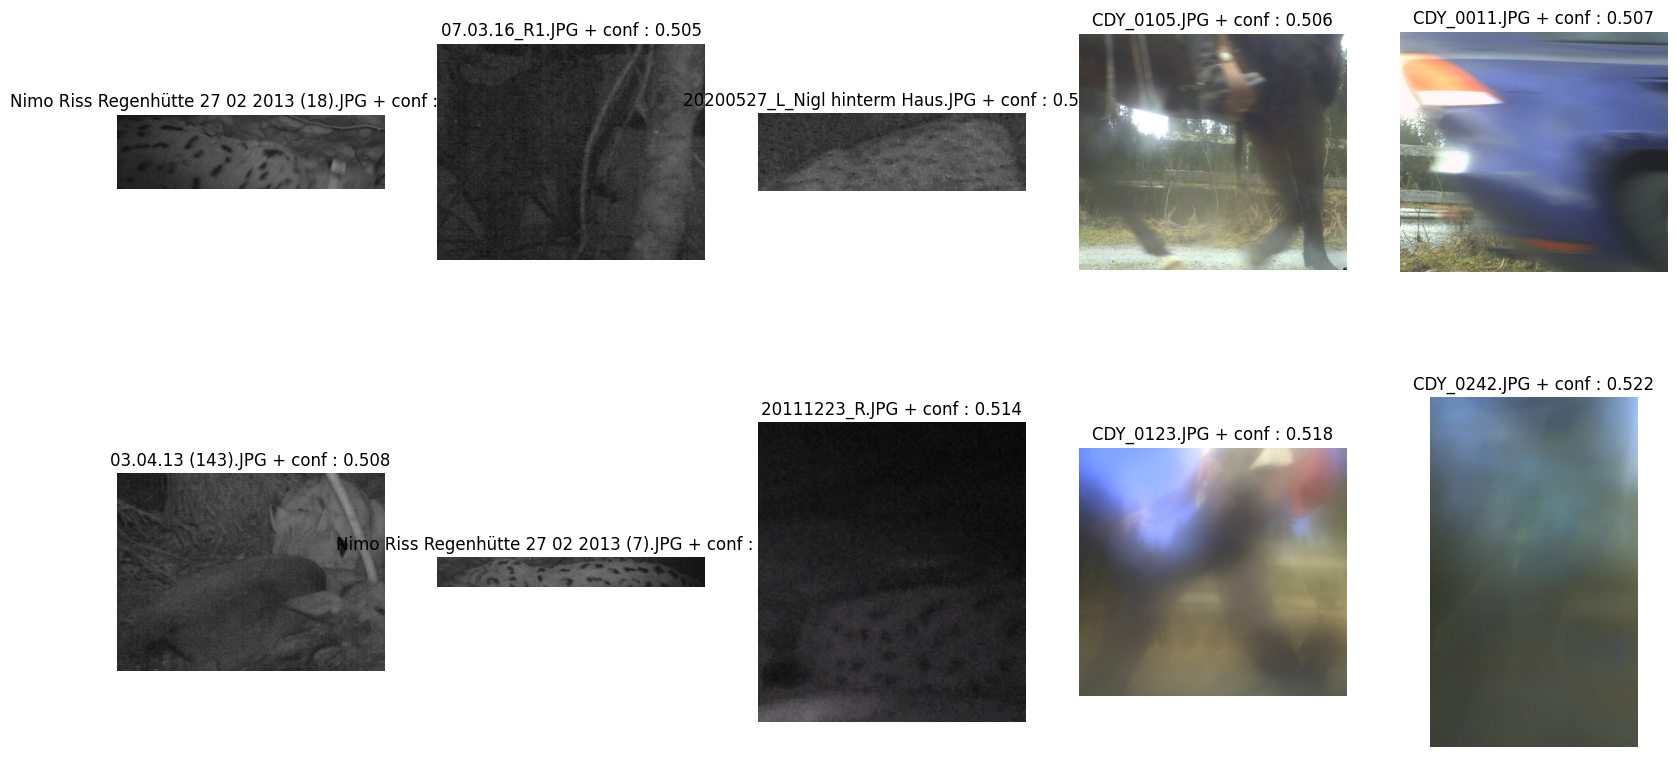

In [32]:
plot_images_conf(df_bbox_country_single_detection, by="smallest")

### **10 images cropped with the largest confidence are displayed**

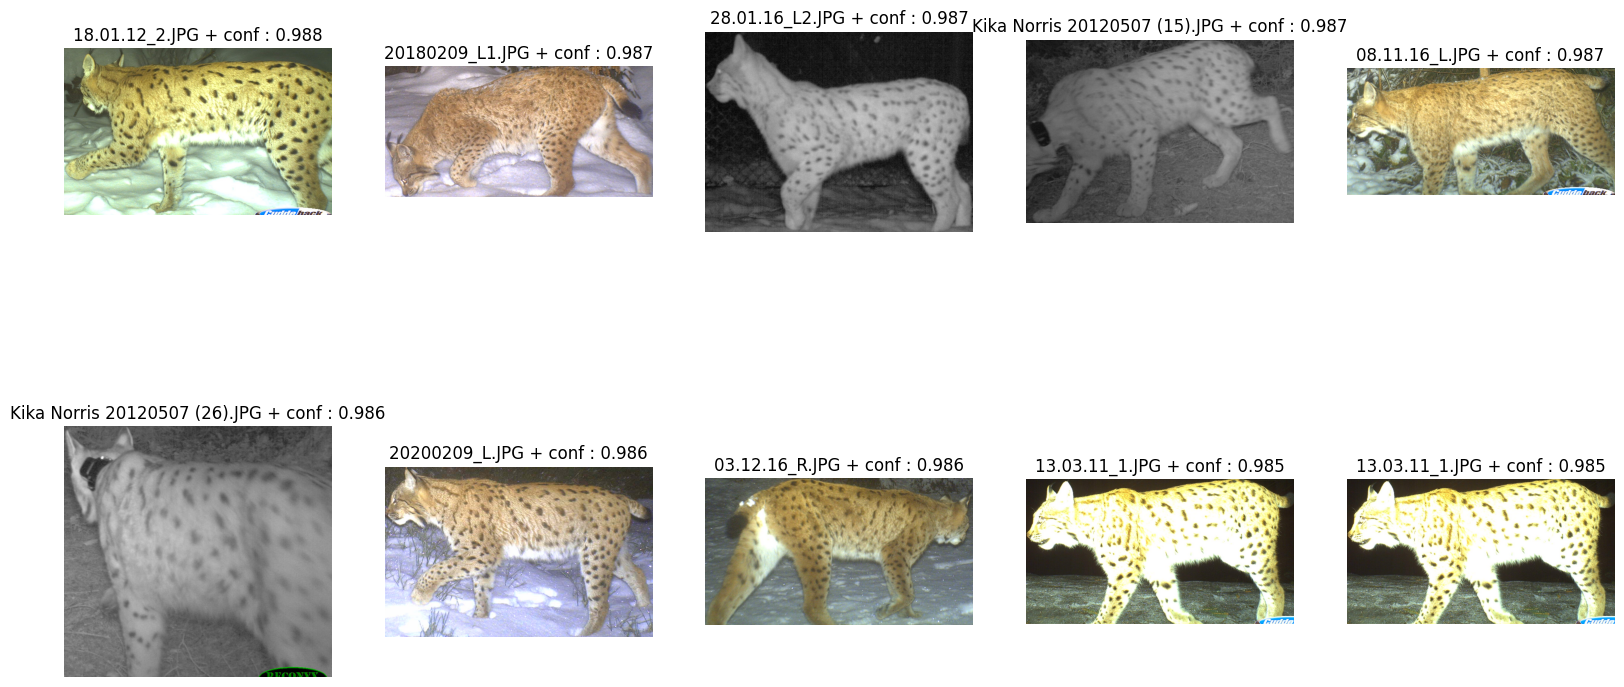

In [33]:
plot_images_conf(df_bbox_country_single_detection, by="largest")

In [34]:
df_country_with_bbox = pd.merge(df_country, df_bbox_country_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_country_with_bbox = df_country_with_bbox.drop('file', axis=1)

df_country_with_bbox

,filepath,lynx_id,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.909,1472.8320,490.9680,379.9680,273.9960
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.929,1638.9120,486.9720,280.8960,287.9280
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.930,1554.8160,486.0000,364.9920,288.9000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.945,389.9392,1140.9408,377.8560,332.8512
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.897,1536.0000,562.9440,510.9760,356.9664
...,...,...,...,...,...,...,...
5126,/gpfsscratch/rech/ads/commun/datasets/extracte...,Luha,0.976,0.0000,660.9408,1440.9728,822.9888
5127,/gpfsscratch/rech/ads/commun/datasets/extracte...,Luha,0.945,706.9696,584.9088,701.8496,396.9024
5128,/gpfsscratch/rech/ads/commun/datasets/extracte...,B31_Geli_Luna_Juv.13_1,0.977,544.9728,461.8752,833.9456,495.9744
5129,/gpfsscratch/rech/ads/commun/datasets/extracte...,B266_Juvenil Neu_2013,0.975,552.9600,613.9392,1000.8576,755.8656


#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

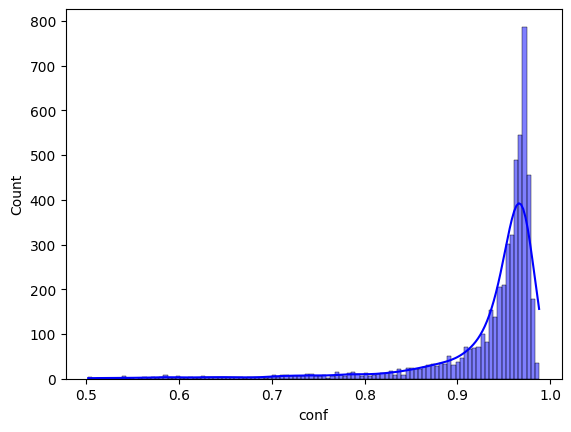

In [35]:
import seaborn as sns

sns.histplot(df_country_with_bbox["conf"], kde=True, color='blue')

## **Compute `image_number` for each individual**

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [36]:
df_country_with_bbox['image_number'] = df_country_with_bbox.groupby('lynx_id').cumcount() + 1
df_country_with_bbox

,filepath,lynx_id,conf,x,y,width,height,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.909,1472.8320,490.9680,379.9680,273.9960,1
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.929,1638.9120,486.9720,280.8960,287.9280,2
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.930,1554.8160,486.0000,364.9920,288.9000,3
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.945,389.9392,1140.9408,377.8560,332.8512,4
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,B30_Hope,0.897,1536.0000,562.9440,510.9760,356.9664,5
...,...,...,...,...,...,...,...,...
5126,/gpfsscratch/rech/ads/commun/datasets/extracte...,Luha,0.976,0.0000,660.9408,1440.9728,822.9888,7
5127,/gpfsscratch/rech/ads/commun/datasets/extracte...,Luha,0.945,706.9696,584.9088,701.8496,396.9024,8
5128,/gpfsscratch/rech/ads/commun/datasets/extracte...,B31_Geli_Luna_Juv.13_1,0.977,544.9728,461.8752,833.9456,495.9744,1
5129,/gpfsscratch/rech/ads/commun/datasets/extracte...,B266_Juvenil Neu_2013,0.975,552.9600,613.9392,1000.8576,755.8656,1


## **Add other information**

In [37]:
needed_columns = ['source', 'pattern', 'date', 'location']
for col in needed_columns:
    if col not in df_country_with_bbox.columns:
        df_country_with_bbox[col] = np.nan

In [38]:
df_country_with_bbox['country'] = COUNTRY

In [39]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

In [5]:
df_country_with_bbox = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

### **Add the `filepath_no_bg` column based on existing images**

In [6]:
df_country_with_bbox['filepath_no_bg'] = df_country_with_bbox.apply(lambda row: check_filepath(NO_BACKGROUND, COUNTRY, row['filepath'], row['lynx_id'], row['image_number']), axis=1)

In [7]:
print(f"Number of images remaining to be calculated: {df_country_with_bbox['filepath_no_bg'].isna().sum()}")

Number of images remaining to be calculated: 5131


In [8]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

In [ ]:
display_slurm_queue(name=f'sam_{COUNTRY}', timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            350855   gpu_p13 sam_germ  uxp55sd  R      34:09      1 r8i0n3


In [7]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [6]:
df_full.groupby('country').nunique()[['filepath', 'filepath_no_bg']]

,filepath,filepath_no_bg
country,,
germany,5131,5131


In [7]:
all_files_exist = df_full['filepath_no_bg'].apply(lambda x: pd.isna(x) or os.path.exists(x)).all()
assert all_files_exist